# 4. Radio Source Maps

## 4.1. Notebook setup

In [1]:
import os
import sys

from cmcrameri import cm as cmc
import emcee
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import smplotlib

In [2]:
epochs = ["A", "B", "C", "D", "E", "F"]
data_path = "../data/"
fig_path = "../figures/"
calibrator = "J0340"
target = "HR1099"

cm = ['#377eb8', '#e41a1c', '#4daf4a', '#dede00', '#ff7f00', '#999999', '#984ea3', '#f781bf', '#a65628']
marker_cycle = ["o", "v", "X", "<", "D", "^"]

sys.path.append(os.path.join(os.getcwd(), ".."))
from library import HR1099_astrometry, utils

deg = np.pi / 180
mas = deg / (60 * 60 * 1000)

## 4.2. Import data

In [3]:
epochs, mean_x, mean_y, mean_jd, mean_x_err, mean_y_err = np.genfromtxt(
    data_path + target + "_I_positions.txt", 
    skip_header=2, 
    dtype="U1,f8,f8,f8,f8,f8,f8,f8",
    usecols=(0, 2, 3, 5, 6, 7),
    unpack=True,
)
mean_mjd = np.round(mean_jd - 2400000.5, 1)

models = {}
for epoch in epochs:
    beam = utils.get_beam(os.path.join(
        data_path, f"{epoch}_{target}_sc.log"
    ))
    models[epoch] = utils.vlb_model(
        os.path.join(data_path, f"{epoch}_{target}_sc.mod"),
        beam
    )
    models[epoch].excise_components(200)

sampler = emcee.backends.HDFBackend(data_path + target + "_orbital_chain.h5")
flat_samples = sampler.get_chain(flat=True)
flat_samples = np.divide(flat_samples, np.array([1, 1, deg, deg]))

med_val = np.percentile(flat_samples, [16, 50, 84], axis=0)
lower_val = med_val[1] - med_val[0]
upper_val = med_val[2] - med_val[1]
med_val = med_val[1]

hr1099 = HR1099_astrometry.HR1099_astrometry(med_val[2] * deg, med_val[3] * deg)
T, P, d, a, m1, m2, R1, R2 = hr1099.hr1099_info()

## 4.3. Plot

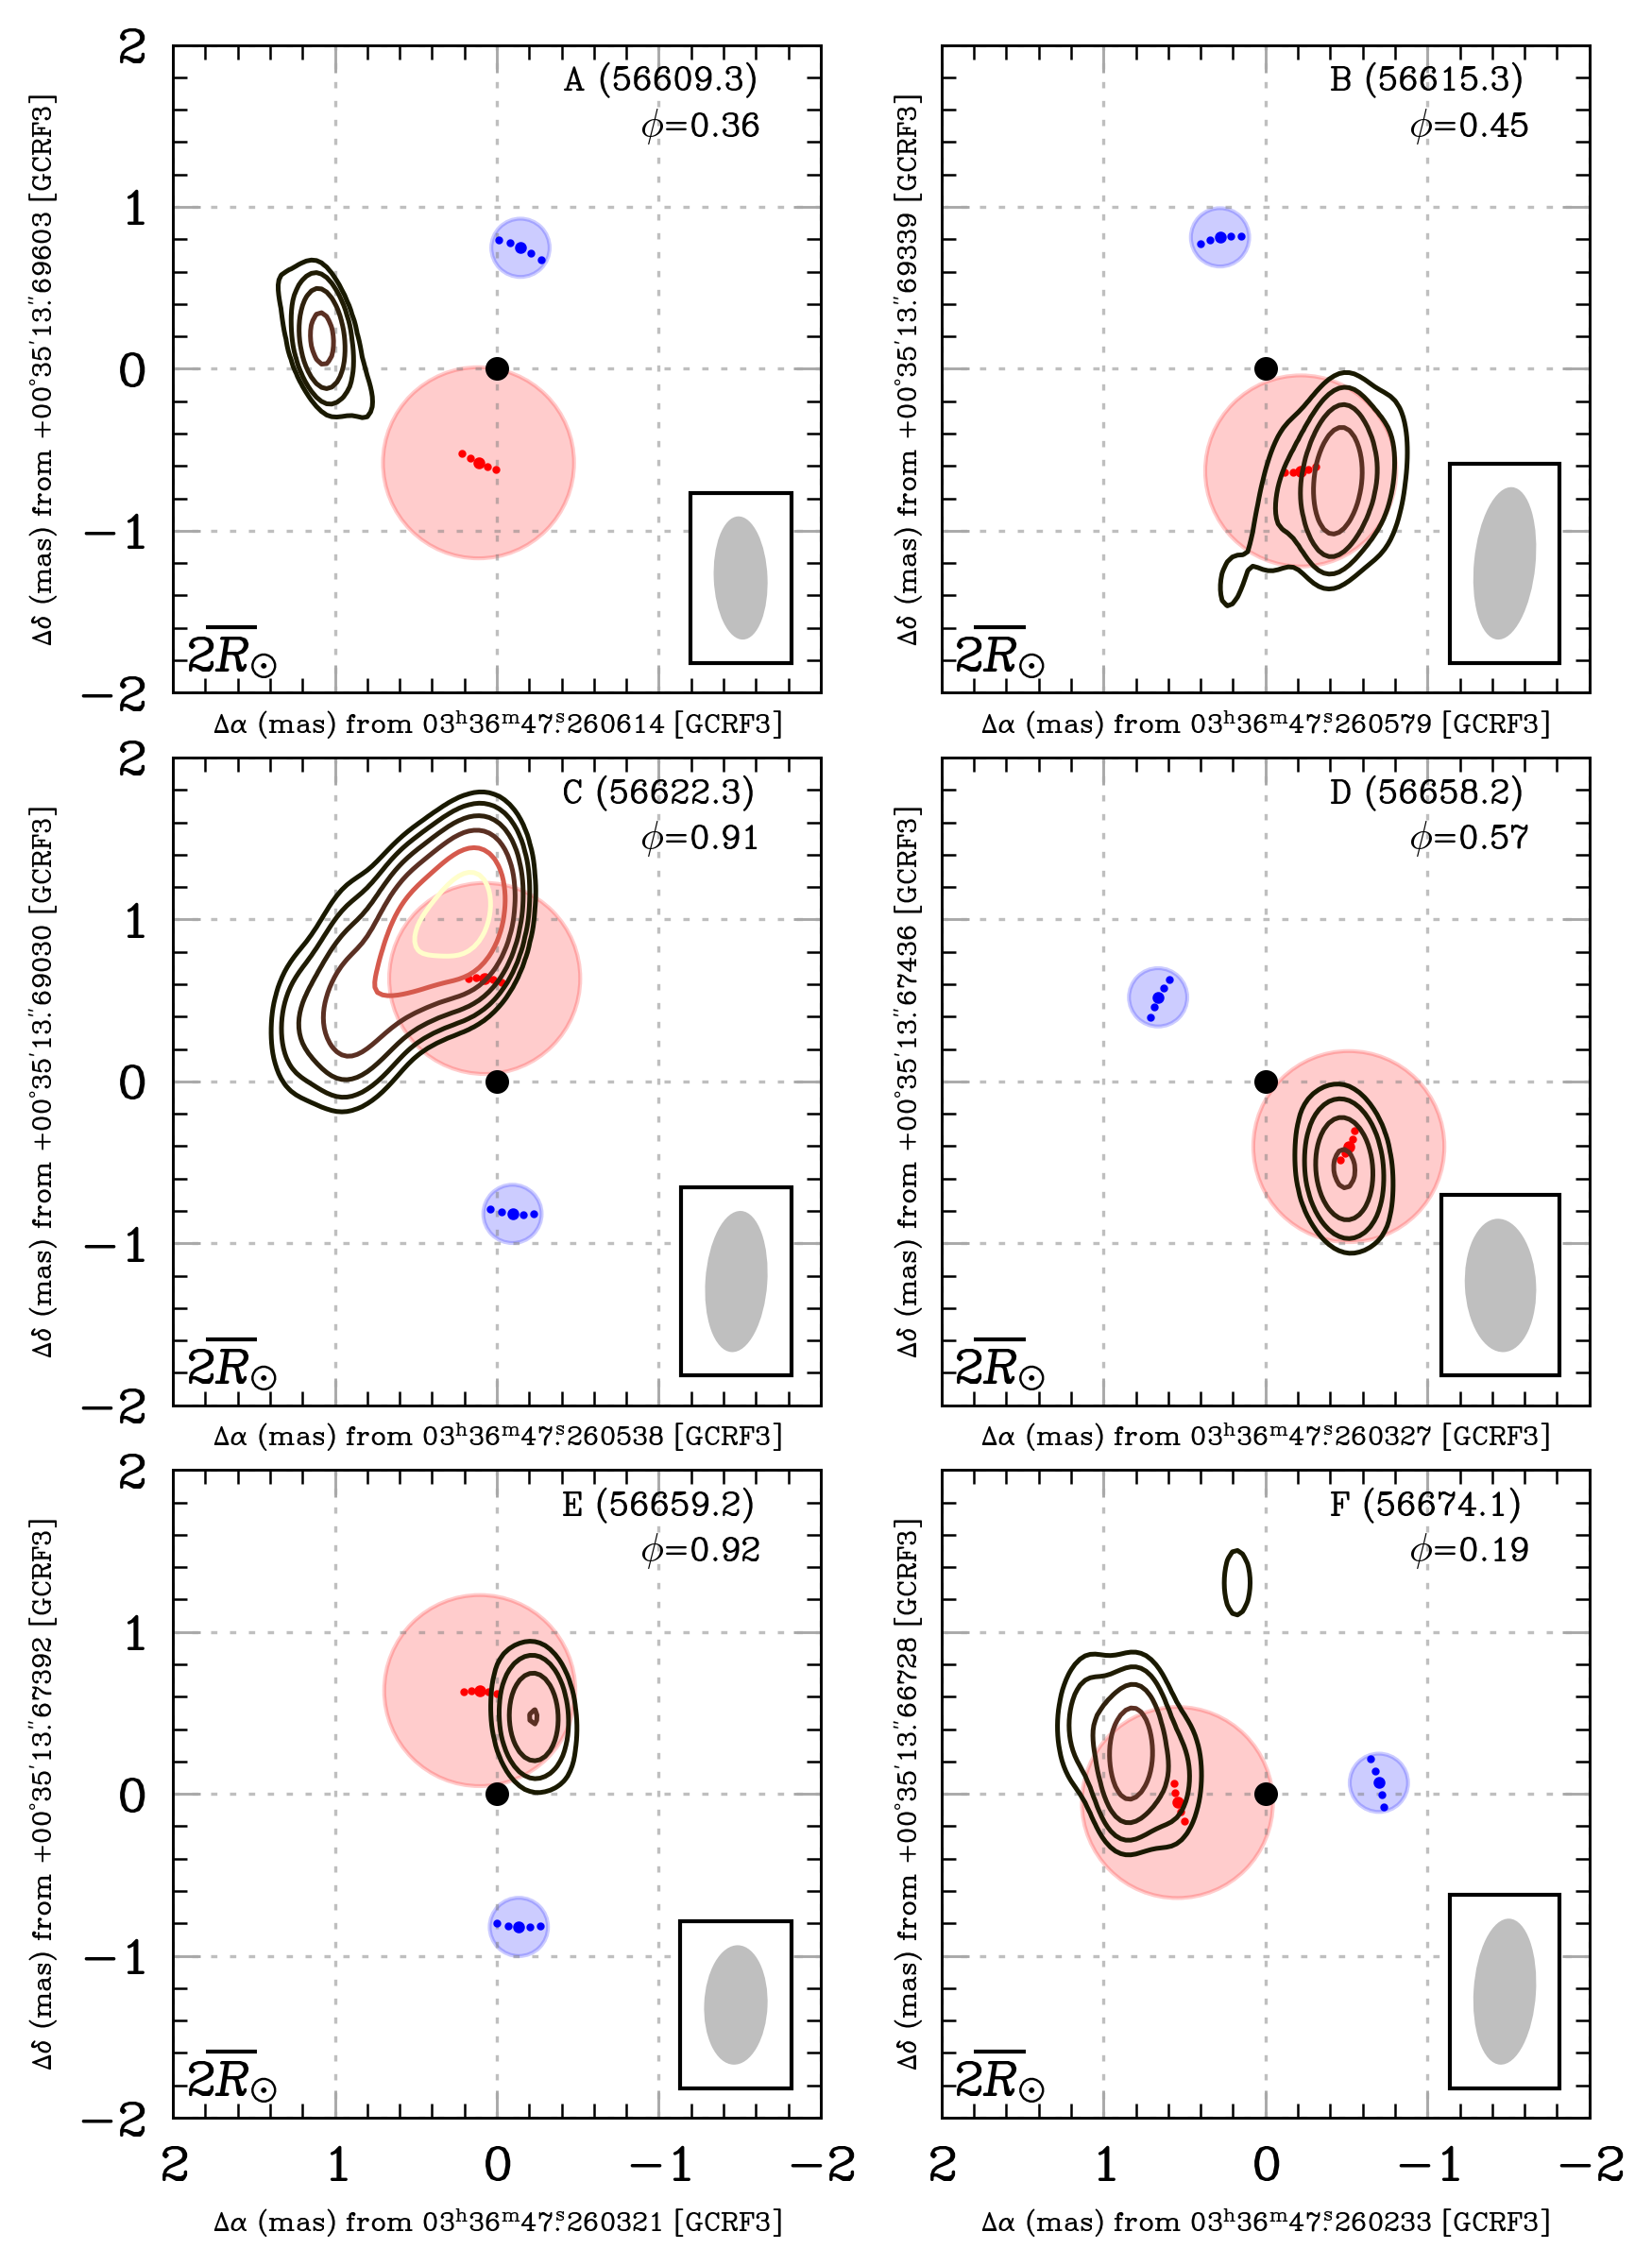

In [4]:
epoch_orbit_phases = []
for i, epoch in enumerate(epochs):
    epoch_orbit_phases.append(hr1099.orbit_phase(mean_jd[i]))
sorted_index = np.argsort(epoch_orbit_phases)

fig, ax = plt.subplots(3, 2, figsize=(7, 9.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0.1)

xx, yy = np.meshgrid(
    np.linspace(-2 * mas, 2 * mas, 256, endpoint=True),
    np.linspace(-2 * mas, 2 * mas, 256, endpoint=True),
)

model_sums = [np.sum(m.get_image_plane_model(xx, yy)) for m in models.values()]
max_lev_scalar = np.max(model_sums)/model_sums

for i, epoch in enumerate(epochs):

    utils.plot_binary(
        ax[i // 2, i % 2],
        hr1099,
        mean_jd[i],
        corotate=False,
        centroid=[mean_x[i]+med_val[0], mean_y[i]+med_val[1], 0, 0],
        label=mean_mjd[i],
        cmap=cmc.lajolla,
        model=models[epoch],
        mapsize=4,
        cells=256,
        levs=[2, 4, 8, 16, 32, 64],
        max_lev_scalar=max_lev_scalar[i],
        beam=models[epoch].restoring_beam,
        show_coord_axes=True,
        hour_range=2,
        fontsize=8,
        d=d,
        bar_pos='lower left',
    )
    ax[i // 2, i % 2].annotate(
        "%s (%.1f)" % (epoch, mean_mjd[i]), xy=(0.6, 0.93), xycoords="axes fraction", fontsize=10
    )
    ax[i // 2, i % 2].annotate(
        r"$\phi$=%.2f" % epoch_orbit_phases[i],
        xy=(0.72, 0.86),
        xycoords="axes fraction",
        fontsize=10,
    )
    ax[i // 2, i % 2].set_aspect("equal")
    ax[i // 2, i % 2].grid(True, linestyle="dotted", alpha=0.5)

fig.set_facecolor("white")
fig.set_dpi(300)
plt.savefig(fig_path + "radio_maps.pdf", bbox_inches="tight")
plt.show()